(a&b) Load Dataset

/var/folders/hr/j14tyw594cs_1fs3tsb5vgrm0000gn/T/ipykernel_42869/4154671769.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(line.strip().split()[0])  # Load image
/var/folders/hr/j14tyw594cs_1fs3tsb5vgrm0000gn/T/ipykernel_42869/4154671769.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(line.strip().split()[0])  # Load image


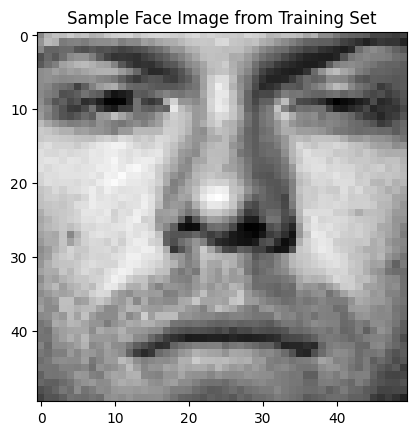

Training data shape: (540, 2500) Training labels shape: (540,)
Testing data shape: (100, 2500) Testing labels shape: (100,)


In [5]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Load the training set
train_labels, train_data = [], []
for line in open('./faces/train.txt'):
    im = imageio.imread(line.strip().split()[0])  
    train_data.append(im.reshape(2500,))  
    train_labels.append(line.strip().split()[1])  

train_data, train_labels = np.array(train_data, dtype=float), np.array(train_labels, dtype=int)

# Adapt sample code to load the testing set
test_labels, test_data = [], []
for line in open('./faces/test.txt'):
    im = imageio.imread(line.strip().split()[0]) 
    test_data.append(im.reshape(2500,))  
    test_labels.append(line.strip().split()[1])  

test_data, test_labels = np.array(test_data, dtype=float), np.array(test_labels, dtype=int)

print("Training data:", train_data.shape, "Training labels:", train_labels.shape)
print("Testing data:", test_data.shape, "Testing labels:", test_labels.shape)

plt.imshow(train_data[10, :].reshape(50, 50), cmap=cm.Greys_r)
plt.title("Sample Face Image, Training Set")
plt.show()



(c) Average Face.

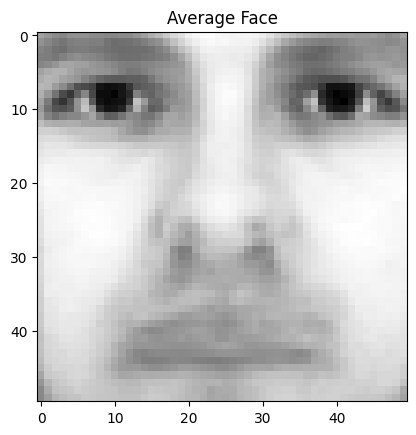

In [6]:
# Compute the average face by summing over rows and dividing by the number of images
average_face = np.mean(train_data, axis=0)

average_face_image = average_face.reshape(50, 50)


plt.imshow(average_face_image, cmap=cm.Greys_r)
plt.title("The Average Face")
plt.show()

(d) Mean Subtraction.

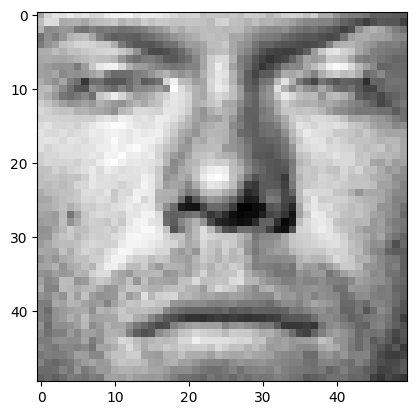

In [17]:
# Subtract the average face from each image in the training sets
train_data_avg_subtracted = train_data - average_face

# Same thing for X_test as well
test_data_avg_subtracted = test_data - average_face

# Display a sample face after mean subtraction (training set)
plt.imshow(train_data_avg_subtracted[10, :].reshape(50, 50), cmap=cm.Greys_r)
plt.show()

(e) Eigenface

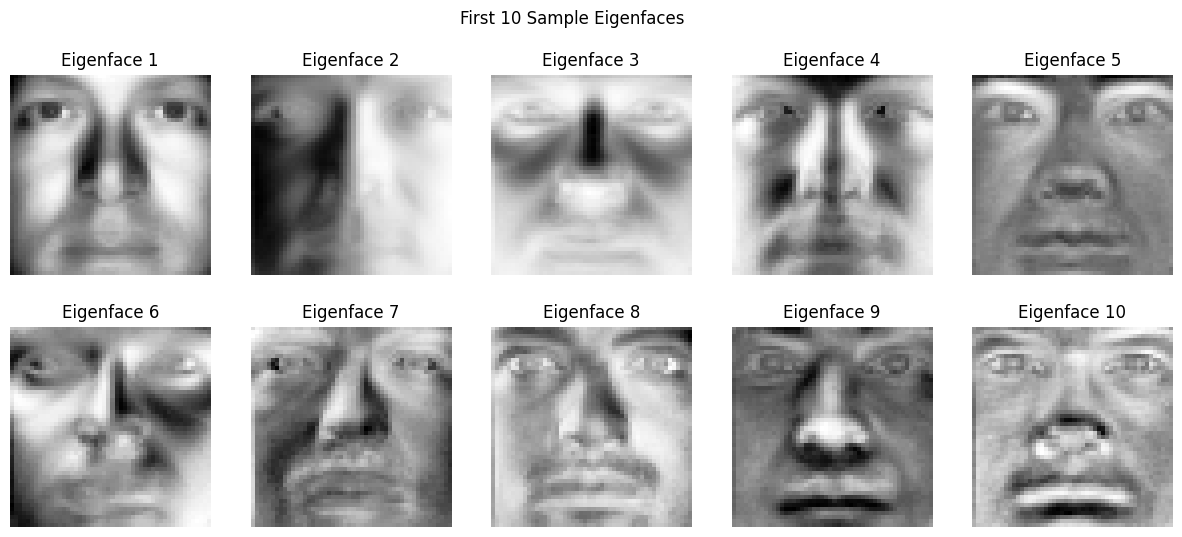

In [18]:
# getcovariance matrix
cov_matrix = np.dot(train_data_avg_subtracted, train_data_avg_subtracted.T)

# eigendecomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
eigenvectors = eigenvectors[:, np.argsort(eigenvalues)[::-1]]
eigenfaces = np.dot(train_data_avg_subtracted.T, eigenvectors)

# nomralize the eigenfaces
eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)

# Display the top 10 eigenfaces as 50x50 grayscale images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    eigenface_image = eigenfaces[:, i].reshape(50, 50)
    # i.imshow(eigenface_image, cmap=cm.Greys_r)
    # make the display a bit better, line by line
    axes[i // 5, i % 5].imshow(eigenface_image, cmap=cm.Greys_r)
    axes[i // 5, i % 5].set_title(f"Eigenface {i+1}")
    axes[i // 5, i % 5].axis('off')
plt.suptitle("First 10 Sample Eigenfaces")
plt.show()

(f) Eigenface Feature

In [21]:
def generate_feature_matrix(data, eigenfaces, r):
    """
    This function: generates the r-dimensional feature matrix for the provided data using the top r eigenfaces.
    """
    # top r rows, transpose of eigenfaces
    top_r_eigenfaces = eigenfaces[:, :r]
    #r-dimensional eigenface space
    F = np.dot(data, top_r_eigenfaces)
    
    return F


r = 10  # use top 10 eigenfaces for now
#  matrices
F_train = generate_feature_matrix(train_data_avg_subtracted, eigenfaces, r)
F_test = generate_feature_matrix(test_data_avg_subtracted, eigenfaces, r)

print("F_train:", F_train.shape) 
print("F_test:", F_test.shape)    

F_train: (540, 10)
F_test: (100, 10)


(g) Face Recognition.

/Users/yuewenyyy/Applied Machine Learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/yuewenyyy/Applied Machine Learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/yuewenyyy/Applied Machine Learning/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/

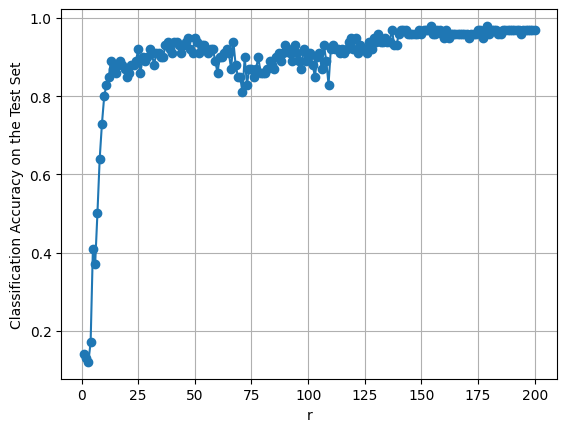

when r=10: 0.8000


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


r_range = range(1, 201) # for plotting r from 1 t0 200
accuracies = []
for r in r_range:
    # Generate r-dimensional feature matrices
    F_train_r = generate_feature_matrix(train_data_avg_subtracted, eigenfaces, r)
    F_test_r = generate_feature_matrix(test_data_avg_subtracted, eigenfaces, r)
    clf = LogisticRegression(max_iter=1000, multi_class='ovr')
    clf.fit(F_train_r, train_labels)
    predictions = clf.predict(F_test_r)
    accuracy = accuracy_score(test_labels, predictions)
    accuracies.append(accuracy)

# plot classification accuracy on the test set as a function of r 
plt.plot(r_range, accuracies, marker='o')
plt.xlabel("r")
plt.ylabel("Classification Accuracy on the Test Set")
plt.grid()
plt.show()


print(f"when r=10: {accuracies[9]:.4f}")

(h) Low-Rank Data Loss.

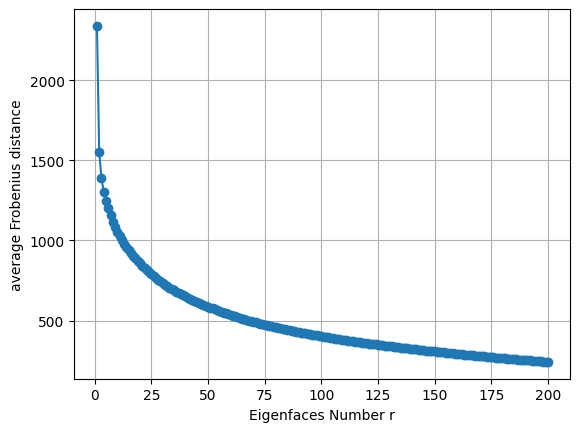

In [28]:

losses = [] #for plotting
for r in range(1, 201):
    F_train_r = generate_feature_matrix(train_data_avg_subtracted, eigenfaces, r)
    top_r_eigenfaces = eigenfaces[:, :r]  
    X_curr = np.dot(F_train_r, top_r_eigenfaces.T) + average_face  # Add the mean face back
    diff = train_data - X_curr
    frobenius_distance = np.sqrt(np.trace(np.dot(diff.T, diff)) / train_data.shape[0]) # from formula
    losses.append(frobenius_distance)

# Plot the reconstruction loss as a function of r
plt.plot(r_values, losses, marker='o')
plt.xlabel("Eigenfaces Number r")
plt.ylabel("average Frobenius distance")
plt.grid()
plt.show()